In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import utilities

# check scikit-learn version
import sklearn
print('sklearn: %s' % sklearn.__version__)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE


sklearn: 0.21.2


In [3]:
# Define estimators to be used.  This time it is Classification (RFC, GBC, SVC)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

In [4]:
# Load input file
rawData = pd.read_csv('default of credit card clients.csv', header=1)

In [5]:
# Take a look at the data
rawData.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
# See what it is made of.
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
DEFAULT      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


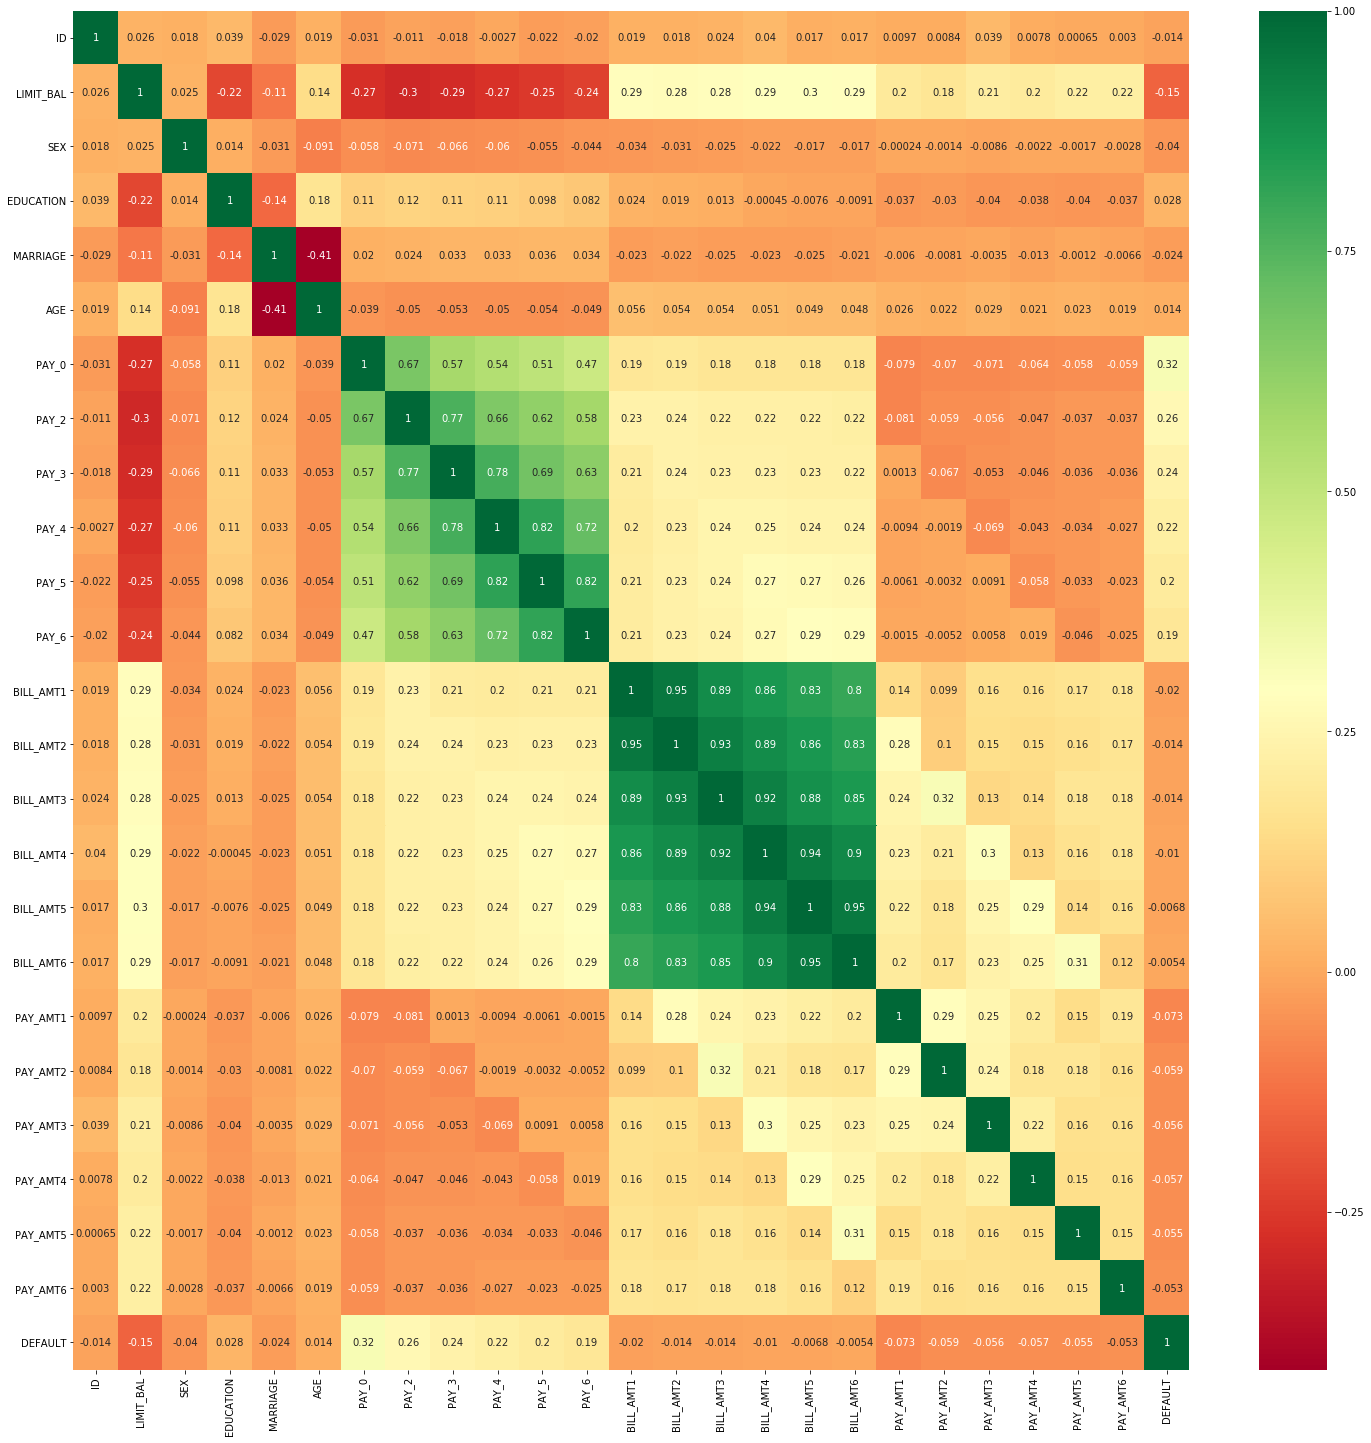

In [7]:
# Start with full file and then run a correlation matrix to find related fields
corrmat = rawData.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,25))
#plot heat map
g=sns.heatmap(rawData[top_corr_features].corr(),annot=True,cmap="RdYlGn")


In [8]:
# Preprocess the data file.
features = rawData.iloc[:,1:24]
print('Summary of feature sample')
features.head()

Summary of feature sample


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [9]:
#dependent variable
depVar = rawData['DEFAULT']
print(depVar)

0        1
1        1
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       1
14       0
15       0
16       1
17       0
18       0
19       0
20       0
21       1
22       1
23       1
24       0
25       0
26       1
27       0
28       0
29       0
        ..
29970    0
29971    0
29972    0
29973    1
29974    1
29975    0
29976    1
29977    0
29978    0
29979    0
29980    0
29981    0
29982    1
29983    0
29984    0
29985    0
29986    0
29987    0
29988    0
29989    0
29990    0
29991    1
29992    0
29993    0
29994    1
29995    0
29996    0
29997    1
29998    1
29999    1
Name: DEFAULT, Length: 30000, dtype: int64


In [10]:
# Let's divide up the file into a 70/30 split and populate xTrain, XTest, yTrain, yTest

xTrain, xTest, yTrain, yTest = train_test_split(features, depVar, test_size = 0.3, random_state = 0)
xTrain.shape, xTest.shape

((21000, 23), (9000, 23))

In [11]:
#Training Set (Feature Space: X Training)

xTrain.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
15925,30000,2,2,2,31,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
10062,200000,1,2,1,31,1,2,2,0,0,...,29192,28170,28763,28453,3019,6,991,1032,1310,2000
19376,500000,2,4,2,38,-2,-2,-2,-2,-2,...,24667,40626,9255,8659,2265,24905,40827,30844,8695,3532
6384,20000,2,2,2,22,0,0,0,0,0,...,39053,20055,19606,19925,1298,1909,1666,5000,703,775
15976,50000,2,2,1,48,1,2,0,0,0,...,19793,19378,18874,19361,0,2000,1500,1000,2000,1000


In [12]:
#Dependent Variable Training Set (y Training)

yTrain_count = len(yTrain.index)
print('The number of observations in the Y training set are:',str(yTrain_count))
yTrain.head()

The number of observations in the Y training set are: 21000


15925    0
10062    0
19376    0
6384     0
15976    1
Name: DEFAULT, dtype: int64

In [13]:
#Testing Set (X Testing)

xTest_count = len(xTest.index)
print('The number of observations in the feature testing set is:',str(xTest_count))
print(xTest.head())

The number of observations in the feature testing set is: 9000
       LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
8225       20000    1          1         2   33      1      2      2      2   
10794      20000    2          2         2   35      0      0      2      0   
9163      230000    2          1         1   44      1     -1     -1     -1   
26591     100000    1          2         1   42      0      0      0      0   
6631      150000    1          1         2   29     -2     -2     -2     -2   

       PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  \
8225       2  ...      19057      18453      19755      19288         0   
10794      0  ...      18600      19000      19000      20000      3400   
9163      -1  ...       2864        933          0          0       949   
26591      0  ...      16138      17758      18774      20272      5000   
6631      -2  ...        831       6469       5138       7810      6989   

       PAY_

In [14]:
#Ground Truth (y Testing) 

yTest_count = len(yTest.index)
print('The number of observations in the Y training set are:',str(yTest_count))
yTest.head()

The number of observations in the Y training set are: 9000


8225     0
10794    0
9163     0
26591    0
6631     0
Name: DEFAULT, dtype: int64

#### At this point the dataframes are ready and we need to prepare the models. ####

In [15]:
param_range = [10,50,100,200,300,500,800,1000,1500]
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)

In [16]:
RF_cls = RandomForestClassifier(n_estimators=300,random_state=0)
scorer = 'accuracy'

In [38]:
#Models
modelSVC = LinearSVC(dual=False,max_iter=2000, tol=0.001)
modelRFC = RandomForestClassifier(n_estimators=150)
modelGBC = GradientBoostingClassifier(n_estimators=300,
                                      subsample=1.0,
                                      max_depth=2,
                                      learning_rate=0.1,
                                      random_state=1)


#### Random Forest Classification Model Fitting and Scoring ####

In [56]:
#Model Fitting

modelRFC.fit(xTrain,yTrain)
print('Cross Validation Score: ',cross_val_score(modelRFC, xTrain, yTrain, cv=5))
RFscore = modelRFC.score(xTrain,yTrain)
print('Mean Accuracy: %.5f' % RFscore)

Cross Validation Score:  [0.81766246 0.81642857 0.81119048 0.80761905 0.81495594]
Mean Accuracy: 0.99971


Variable Importance:


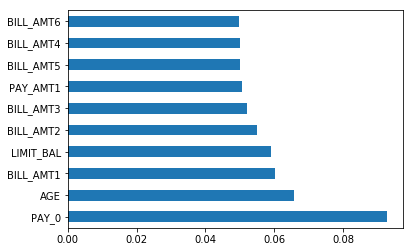

PAY_0        0.092698
AGE          0.065671
BILL_AMT1    0.060224
LIMIT_BAL    0.058958
BILL_AMT2    0.054933
BILL_AMT3    0.051958
PAY_AMT1     0.050520
BILL_AMT5    0.050138
BILL_AMT4    0.050017
BILL_AMT6    0.049858
dtype: float64


In [57]:
RFC_feature_importances = pd.Series(modelRFC.feature_importances_,
                                    index = xTrain.columns)
print('Variable Importance:')
RFC_feature_importances.nlargest(10).plot(kind='barh')
plt.show()
print(RFC_feature_importances.nlargest(10))

#### Can we play with the estimators to improve the accuracy? ####

In [27]:
train_scores, test_scores = validation_curve(RF_cls, xTrain, yTrain, 
                                             'n_estimators',
                                             param_range=param_range,
                                             cv=crossvalidation,
                                             scoring='accuracy')

In [28]:
mean_test_scores = np.mean(test_scores, axis=1)

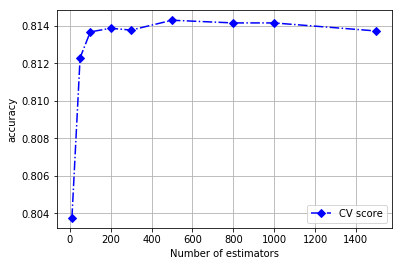

In [29]:
plt.plot(param_range, mean_test_scores,
        'bD-.', label='CV score')
plt.grid()
plt.xlabel('Number of estimators')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show();

#### Using GridSearch to determine if there are better parameters to use ####

In [31]:
# Use GridSearchCV to optimize RF
max_features = [xTrain.shape[1]//3, 'sqrt', 'log2', 'auto']
min_samples_leaf = [1, 10, 30]
n_estimators = [50,100,200]
search_grid = {'n_estimators':n_estimators,
              'max_features': max_features,
              'min_samples_leaf': min_samples_leaf}
search_func = GridSearchCV(estimator=RF_cls,
                          param_grid=search_grid,
                          scoring=scorer,
                          cv=crossvalidation)
search_func.fit(xTrain,yTrain)
best_params = search_func.best_params_
best_score = search_func.best_score_
print('Best parameters: %s' % best_params)
print('Best accuracy: %.5f' % best_score)

Best parameters: {'max_features': 7, 'min_samples_leaf': 30, 'n_estimators': 50}
Best accuracy: 0.81790


#### Support Vector Classification Model Fitting and Scoring ####

In [39]:
modelSVC.fit(xTrain,yTrain)
print('Cross Validation Score: ',cross_val_score(modelSVC, xTrain, yTrain, cv=10)) 
SVCscore = modelSVC.score(xTrain,yTrain)
print('Mean Accuracy: %.5f' % SVCscore)

Cross Validation Score:  [0.776297   0.776297   0.776297   0.776297   0.77619048 0.77619048
 0.77656027 0.77608385 0.77608385 0.77656027]
Mean Accuracy: 0.77633


In [51]:
# See if we can improve the results using RFE.
rfe = RFE(modelSVC, 10)
rfe = rfe.fit(xTrain,yTrain)
rfesupport = pd.DataFrame(rfe.support_)
rfecolumns = pd.DataFrame(xTrain.columns)
rferanking = pd.DataFrame(rfe.ranking_)
rfeResults = pd.concat([rfecolumns,rfesupport,rferanking], axis=1)
rfeResults.columns = ['Attribute','Support','Ranking']
print("Number of Features: %d " % rfe.n_features_)
print(rfeResults.nsmallest(10,'Ranking'))


Number of Features: 10 
    Attribute  Support  Ranking
0   LIMIT_BAL     True        1
11  BILL_AMT1     True        1
12  BILL_AMT2     True        1
13  BILL_AMT3     True        1
15  BILL_AMT5     True        1
17   PAY_AMT1     True        1
18   PAY_AMT2     True        1
19   PAY_AMT3     True        1
20   PAY_AMT4     True        1
21   PAY_AMT5     True        1


#### Gradient Boosting Classifier Model Fitting and Scoring ####

In [52]:
modelGBC.fit(xTrain,yTrain)
print('Cross Validation Score: ',cross_val_score(modelGBC, xTrain, yTrain, scoring=scorer,cv=crossvalidation)) 
GBCscore = modelGBC.score(xTrain,yTrain)
print('Mean Accuracy: %.5f' % GBCscore)

Cross Validation Score:  [0.81547619 0.82690476 0.80952381 0.81619048 0.81928571]
Mean Accuracy: 0.82433


Variable Importance:


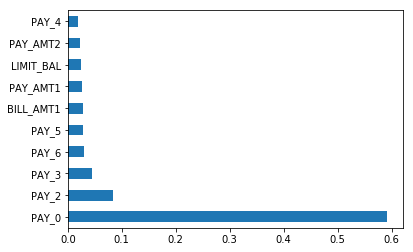

PAY_0        0.590767
PAY_2        0.084219
PAY_3        0.045629
PAY_6        0.029335
PAY_5        0.028541
BILL_AMT1    0.027976
PAY_AMT1     0.026521
LIMIT_BAL    0.024342
PAY_AMT2     0.021851
PAY_4        0.018450
dtype: float64


In [53]:
GBC_feature_importances = pd.Series(modelGBC.feature_importances_,
                                   index = xTrain.columns)
print('Variable Importance:')
GBC_feature_importances.nlargest(10).plot(kind='barh')
plt.show()
print(GBC_feature_importances.nlargest(10))

In [58]:
print('Training Model Scores: ')
print('RF  : \t %.5f' % RFscore)
print('SVC : \t %.5f' % SVCscore)
print('GBC : \t %.5f' % GBCscore)

Training Model Scores: 
RF  : 	 0.99971
SVC : 	 0.77633
GBC : 	 0.82433


#### Trained Model Performance ####

In [59]:
#Model Performance
rSquared = RFscore
mse = np.mean((modelRFC.predict(xTest) - yTest) ** 2)
print('Mean squared error: %.2f' % mse + ': (Lower numbers are better)')
print('R Squared of training: %.2f' % rSquared + ': (Higher numbers are better, but be careful of overfitting)')

Mean squared error: 0.18: (Lower numbers are better)
R Squared of training: 1.00: (Higher numbers are better, but be careful of overfitting)


In [60]:
#Model Performance
rSquared = GBCscore
mse = np.mean((modelGBC.predict(xTest) - yTest) ** 2)
print('Mean squared error: %.2f' % mse + ': (Lower numbers are better)')
print('R Squared of training: %.2f' % rSquared + ': (Higher numbers are better, but be careful of overfitting)')

Mean squared error: 0.18: (Lower numbers are better)
R Squared of training: 0.82: (Higher numbers are better, but be careful of overfitting)


#### Make Predictions with Trained Model ####

In [61]:
# Making RF predictions
predictions = modelRFC.predict(xTest)
print('\nClassification report:\n ', classification_report(yTest, predictions))
print('\nKappa: %.7f' % cohen_kappa_score(yTest,predictions))
print('\nConfusion matrix (Future DEFAULT):\n    No\t Yes\n',confusion_matrix(yTest, predictions))



Classification report:
                precision    recall  f1-score   support

           0       0.84      0.95      0.89      7060
           1       0.65      0.36      0.46      1940

    accuracy                           0.82      9000
   macro avg       0.75      0.65      0.68      9000
weighted avg       0.80      0.82      0.80      9000


Kappa: 0.3666149

Confusion matrix (Future DEFAULT):
    No	 Yes
 [[6679  381]
 [1238  702]]


In [62]:
# Making Decision Tree predictions
predictions = modelGBC.predict(xTest)
print('\nClassification report:\n ', classification_report(yTest, predictions))
print('\nKappa: %.7f' % cohen_kappa_score(yTest,predictions))
print('\nConfusion matrix (Future DEFAULT):\n    No\t Yes\n',confusion_matrix(yTest, predictions))




Classification report:
                precision    recall  f1-score   support

           0       0.84      0.95      0.89      7060
           1       0.67      0.36      0.47      1940

    accuracy                           0.82      9000
   macro avg       0.76      0.66      0.68      9000
weighted avg       0.81      0.82      0.80      9000


Kappa: 0.3731043

Confusion matrix (Future DEFAULT):
    No	 Yes
 [[6709  351]
 [1240  700]]
